# ANOVA demo

## Consider data generated from a linear function $y = 1 + 2x + 3x^2 + 0x^3 + \varepsilon$:

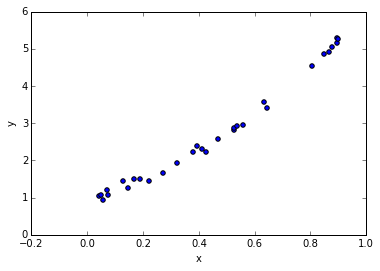

In [57]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### ANOVA for regression
import numpy as np
from scipy.stats import t, f
import statsmodels.api as sm

n_samples = 30
true_fun = lambda X: 1 + 2*X + 3*X**2 + 0*X**3
X = np.sort(np.random.rand(n_samples))
X1 = np.vstack((X**0,X**1,X**2,X**3)).T
y = true_fun(X) + np.random.randn(n_samples) * 0.1
plt.scatter(X,y)
plt.xlabel("x")
plt.ylabel("y")


# Train a linear model $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3$:

In [58]:
# Fit regression model
results = sm.OLS(y, X1).fit()

# Inspect the results
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2753.
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           1.20e-32
Time:                        16:45:44   Log-Likelihood:                 32.683
No. Observations:                  30   AIC:                            -57.37
Df Residuals:                      26   BIC:                            -51.76
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9108      0.064     14.187      0.0

# Double check the F statistic using its definition:

In [59]:
# calculate F statistic
p = X1.shape[1] # model dof
beta = np.linalg.solve(np.dot(X1.T,X1),np.dot(X1.T,y)) # coefficients
ybar = y.mean() # sample mean
yhat = np.dot(X1,beta)
MSM = np.linalg.norm(yhat-ybar)**2/(p-1)
MSE = np.linalg.norm(yhat-y)**2/(n_samples-p)
F = MSM/MSE
print F

2752.88088019


# Perform f-test directly on all model parameters
## This should lead to the same result as from model summary

In [60]:
results.f_test("x1 = x2 = x3 = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 2752.88088019]]), p=1.19702419026e-32, df_denom=26, df_num=3>

# Perform f-tests on part of the model parameters 

In [62]:
results.f_test("x2 = x3 = 0")

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[ 91.15361031]]), p=1.78442092775e-12, df_denom=26, df_num=2>

# Calculate confidence intervals for estimators ($\beta^*$)

## Recall $Var(\beta^*) = (X^TX)^{-1}\sigma^2$

## 1. Estimate $\sigma^2$ with its sample variance $s^2 = \frac{||y-X\beta^*||^2}{n-p}$

In [63]:
# check std on each coefficient
sigma2 = np.sum((y-np.dot(X1,beta.T))**2)/(y.size-p)
print sigma2

0.0076452642955


## 2. Calculate the diagonal line of $(X^TX)^{-1}$, scaled by $s^2$

In [64]:
std = np.sqrt(np.matrix.diagonal(np.linalg.inv(np.dot(X1.T,X1))*sigma2))
print std

[ 0.06419717  0.68470964  1.77416724  1.24394849]


## These are the estimated standard deviations of $\beta^*_0,~\beta^*_1,~\beta^*_2,~\beta^*_3$ 

## Let's double check with the model summary table:

In [65]:
# Inspect the results
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2753.
Date:                Thu, 05 Nov 2015   Prob (F-statistic):           1.20e-32
Time:                        17:11:32   Log-Likelihood:                 32.683
No. Observations:                  30   AIC:                            -57.37
Df Residuals:                      26   BIC:                            -51.76
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9108      0.064     14.187      0.0

## Consider each estimator as some "sample mean", with its std, we can calculate a T statistic to test if the estimator should be zero: $t = \frac{\beta^*_i-0}{s_i}$

In [66]:
beta/std

array([ 14.18676962,   3.84651907,   0.79110123,   0.91594455])

## We can then calculate the p-values, i.e., $P(T>|t|)$:

In [67]:
(1-t.cdf(np.abs(beta/std), y.size-p))*2

array([  9.41469125e-14,   6.96755138e-04,   4.36042546e-01,
         3.68113785e-01])

## Lastly, let's calculate the confidence interval: $CI_i = [\beta^*_i - t_{\alpha/2}s_i, \beta^*_i + t_{\alpha/2}s_i]$:

In [68]:
beta + t.ppf(0.975, y.size-p)*std

array([ 1.04270968,  4.04118951,  5.05039886,  3.69636058])

In [69]:
beta - t.ppf(0.975, y.size-p)*std

array([ 0.77879132,  1.22630787, -2.24330711, -1.4175849 ])

# ANOVA and CI helps to identify if a set of parameters should be all zeros or not. Dropping each parameter, however, will change the conclusions previously made on other model parameters! 

# One way to automatically identify all significant parameters is to use LASSO:

In [70]:
from sklearn.linear_model import LassoCV, Lasso

model=LassoCV(cv=3, fit_intercept=False) #alpha based on CV for ncv from above

model.fit(X1, y)

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [71]:
print model.coef_

[ 0.92329473  2.40181739  2.17166351  0.51400825]


## compare with OLS estimators:

In [47]:
print beta

[ 0.98228521  1.79480323  3.84516716 -0.65983481]


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Compare two sample t-test and one way ANOVA


([array([  81.,  100.,  110.,   92.,  102.,  108.,   97.,  117.,   93.,  100.]),
  array([  99.,   95.,   97.,   97.,  100.,  105.,  107.,   96.,  107.,   97.])],
 array([ 0.00116566,  0.10101595,  0.20086623,  0.30071652,  0.40056681,
         0.50041709,  0.60026738,  0.70011767,  0.79996795,  0.89981824,
         0.99966853]),
 <a list of 2 Lists of Patches objects>)

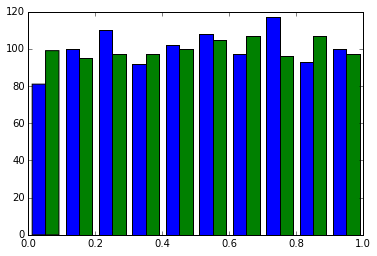

In [50]:
nobs = 1000
b2 = 0
b1 = 0.0
b0 = 0.2
X1 = b2 + np.random.random(nobs)
X2 = b2 + b1 + np.random.random(nobs)
plt.hist( [X1, X2] , stacked=False)

## two sample t-test

In [53]:
from scipy.stats import ttest_ind
ttest_ind(X1,X2)

(0.33752452159938079, 0.73575698496719322)

## ANOVA

In [52]:
from scipy.stats import f_oneway
f_oneway(X1,X2)

(0.11392280268194127, 0.73575698496606456)

# Here is a proof that two sample t-test and ANOVA are the same:

For t-test, the T statistic is
\begin{equation}
T = \frac{\bar{x}_1-\bar{x}_2}{\sqrt{S_p^2 (1/n_1 + 1/n_2)}}
\end{equation}

For ANOVA, we have the model $y = \beta_0 + \beta_1 x$. By minimizing the sum of squared errors, we can get $\beta_0^* = \bar{x}_1$, and $\beta_1^* = \bar{x}_2 - \bar{x}_1$. 

The unexplained variance of the model is
\begin{equation}
(\sum_{i=1}^{n_1}(x_1^{(i)}-\bar{x}_1)^2 + \sum_{i=1}^{n_2}(x_2^{(i)}-\bar{x}_2)^2)/(n_1+n_2-p) = S_p^2
\end{equation}

Let the sample mean be $\bar{x} = \frac{\sum_{i=1}^{n_1} x_1 + \sum_{i=1}^{n_2} x_2}{n_1+n_2}$. The explained variance of the model is
\begin{equation}
\begin{aligned}
& \frac{(\bar{x}_1 - \bar{x})^2 + (\bar{x}_2 - \bar{x})^2}{p-1}\\
=& \frac{(\bar{x}_1 - \bar{x}_2)^2}{1/n_1 + 1/n_2}
\end{aligned}
\end{equation}

Therefore $F = \frac{(\bar{x}_1 - \bar{x}_2)^2}{S_p^2(1/n_1 + 1/n_2)} = T^2$

## Test three sample means with ANOVA

(179.43088709487222, 2.498584736823304e-74)

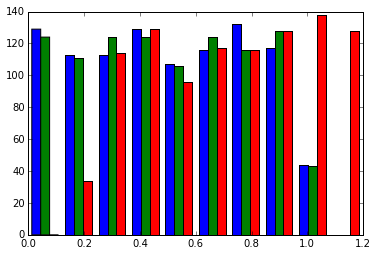

In [54]:
nobs = 1000
b2 = 0
b1 = 0.0
b0 = 0.2
X1 = b2 + np.random.random(nobs)
X2 = b2 + b1 + np.random.random(nobs)
X3 = b2 + b1 + b0 + np.random.random(nobs)
plt.hist( [X1, X2, X3] , stacked=False)

# one way ANOVA on three groups
f_oneway(X1,X2,X3)
